## Libraries

In [ ]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
from time import time

from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, StandardScaler, PCA
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit

from xgboost.spark import SparkXGBRegressor


## Bigquery

Create a BigQuery client instance for accessing and querying the dataset. 'bdcc-451416' is the Google Cloud project ID associated with the BigQuery resources.

This client will be used to perform SQL queries on large-scale ICU data stored in the cloud.

In [2]:
client = bigquery.Client(project="bdcc-451416")

This query creates or replaces a BigQuery table that combines ICU stay data with patient demographics. It joins the 'ICUSTAYS' table with the 'PATIENTS' table using SUBJECT_ID, allowing gender and date of birth (DOB) to be added to each ICU record. The patient's age at the time of ICU admission is calculated using DATE_DIFF, and only those with plausible ages between 1 and 100 years are included to exclude likely data entry errors or anonymized outliers. This preprocessing step is critical for ensuring that future models have meaningful and clean features to work with.

In [3]:
start = time()

query = """
CREATE OR REPLACE TABLE `bdcc-451416.Dataset1.Dataset` AS
SELECT
  icu.*,
  p.GENDER,
  p.DOB,
  DATE_DIFF(DATE(icu.INTIME), DATE(p.DOB), YEAR) AS AGE
FROM
  `bdcc-451416.Dataset1.ICUSTAYS` AS icu
LEFT JOIN
  `bdcc-451416.Dataset1.PATIENTS` AS p
ON
  icu.SUBJECT_ID = p.SUBJECT_ID
WHERE
  DATE_DIFF(DATE(icu.INTIME), DATE(p.DOB), YEAR) BETWEEN 1 AND 100
"""

# Run the query and store results
client.query(query).result()

print(f"Took {time() - start} seconds")

Took 2.2223360538482666 seconds


To further enrich the existing ICU dataset, this step joins it with relevant information from the ADMISSIONS table. The goal is to add contextual features related to the hospital admission—such as admission type (e.g., emergency or elective), location, insurance type, ethnicity, religion, and marital status—which are often significant predictors in healthcare-related models. The join uses both SUBJECT_ID and HADM_ID for precise matching per admission episode. The result is written back to the same BigQuery table using CREATE OR REPLACE to maintain pipeline continuity without generating redundant tables.

In [4]:
start = time()

query = """
CREATE OR REPLACE TABLE `bdcc-451416.Dataset1.Dataset` AS
SELECT
  af.*,
  a.ADMISSION_TYPE,
  a.ADMISSION_LOCATION,
  a.INSURANCE,
  a.ETHNICITY,
  a.RELIGION,
  a.MARITAL_STATUS
FROM `bdcc-451416.Dataset1.Dataset` AS af
LEFT JOIN (
  SELECT
    SUBJECT_ID,
    HADM_ID,
    ADMISSION_TYPE,
    ADMISSION_LOCATION,
    INSURANCE,
    ETHNICITY,
    RELIGION,
    MARITAL_STATUS
  FROM `bdcc-451416.Dataset1.ADMISSIONS`
) AS a
ON af.SUBJECT_ID = a.SUBJECT_ID AND af.HADM_ID = a.HADM_ID
"""

client.query(query).result()

print(f"Took {time() - start} seconds")

Took 1.8457326889038086 seconds


In this stage, the dataset is augmented with a new feature: the number of diagnoses associated with each hospital admission (HADM_ID). This is achieved by joining the main dataset with an aggregated subquery on the DIAGNOSES_ICD table, which counts the diagnostic codes per admission. This count serves as a proxy for patient complexity or illness severity. A LEFT JOIN ensures all records from the main dataset are retained—even when no diagnoses exist (in which case the count is NULL and converted to 0 using IFNULL). The enriched dataset is then written back to the same table to maintain a clean, linear transformation pipeline.

In [5]:
start = time()

query = """
CREATE OR REPLACE TABLE `bdcc-451416.Dataset1.Dataset` AS
SELECT
  d.*,
  IFNULL(dx.NUM_DIAGNOSES, 0) AS NUM_DIAGNOSES
FROM `bdcc-451416.Dataset1.Dataset` AS d
LEFT JOIN (
  SELECT
    HADM_ID,
    COUNT(*) AS NUM_DIAGNOSES
  FROM `bdcc-451416.Dataset1.DIAGNOSES_ICD`
  GROUP BY HADM_ID
) AS dx
ON d.HADM_ID = dx.HADM_ID
"""

client.query(query).result()

print(f"Took {time() - start} seconds")


Took 2.150588035583496 seconds


## Feature Engineering

To transform diagnosis codes into model-friendly features, this step identifies the 100 most frequent ICD9 diagnosis codes and converts them into binary (one-hot) columns. A SQL query first retrieves the top codes from the DIAGNOSES_ICD table, and the data is then pivoted so that each code becomes a separate column indicating its presence (1) or absence (0) for each hospital admission (HADM_ID). Column names are cleaned to ensure BigQuery compatibility. These features are added to the dataset via a left join, creating a structured input for downstream machine learning models.

In [6]:
start = time()

# Get top 100 ICD9 codes from BigQuery
top_codes_query = """
SELECT ICD9_CODE
FROM `bdcc-451416.Dataset1.DIAGNOSES_ICD`
GROUP BY ICD9_CODE
ORDER BY COUNT(*) DESC
LIMIT 100
"""

top_codes_df = client.query(top_codes_query).to_dataframe()
top_codes = top_codes_df["ICD9_CODE"].tolist()

# Sanitize column names: replace '.' with '_', prefix with ICD9_
code_map = {code: f"{code.replace('.', '_')}" for code in top_codes}

# Format for BigQuery pivot IN clause and SELECT
pivot_in_clause = ", ".join(f"'{code}'" for code in top_codes)
select_clause = ",\n  ".join(
    f"IFNULL(p.`{code}`, 0) AS `{alias}`"
    for code, alias in code_map.items()
)

# Construct final SQL
pivot_query = f"""
CREATE OR REPLACE TABLE `bdcc-451416.Dataset1.Dataset` AS
WITH filtered AS (
  SELECT HADM_ID, ICD9_CODE
  FROM `bdcc-451416.Dataset1.DIAGNOSES_ICD`
  WHERE ICD9_CODE IN ({pivot_in_clause})
),
onehot AS (
  SELECT HADM_ID, ICD9_CODE, 1 AS present FROM filtered
),
pivoted AS (
  SELECT * FROM onehot
  PIVOT (
    MAX(present) FOR ICD9_CODE IN ({pivot_in_clause})
  )
)
SELECT
  d.*,
  {select_clause}
FROM `bdcc-451416.Dataset1.Dataset` d
LEFT JOIN pivoted p
ON d.HADM_ID = p.HADM_ID
"""

# Run the query
client.query(pivot_query).result()

print(f"Took {time() - start} seconds")


Took 5.230260848999023 seconds


Advanced feature engineering is performed here by extracting time-windowed summary statistics from the CHARTEVENTS table, which logs high-frequency ICU measurements. The process starts by selecting the 100 most frequent ITEMIDs. For each ICU stay (ICUSTAY_ID), only events from the first 24 hours are retained. Measurements are min-max scaled by their unit (VALUEUOM), and for each ITEMID, the mean, min, max, and standard deviation are calculated. These are then pivoted into wide format (e.g., ITEM_220045_MEAN), and the resulting features are joined to the main dataset, enriching it with normalized physiological trends.

In [7]:
start = time()

top_items_query = """
SELECT ITEMID
FROM `bdcc-451416.Dataset1.CHAREVENTS`
GROUP BY ITEMID
ORDER BY COUNT(*) DESC
LIMIT 100
"""
top_items = client.query(top_items_query).to_dataframe()["ITEMID"].tolist()

# Generate pivot clause and final SELECT fields
pivot_clause = ", ".join([f"'{item}'" for item in top_items])
agg_stats = ['MEAN', 'MIN', 'MAX', 'STD']
select_exprs = [
    f"IFNULL(p.`{item}_{stat}`, 0) AS `ITEM_{item}_{stat}`"
    for item in top_items for stat in agg_stats
]
select_clause = ",\n  ".join(select_exprs)

# Step 2: PIVOT + AGGREGATE query (write to intermediate table)
pivot_query = f"""
CREATE OR REPLACE TABLE `bdcc-451416.Dataset1.pivoted_chartevents_24h` AS
WITH chart_with_intime AS (
  SELECT
    ce.ICUSTAY_ID,
    ce.ITEMID,
    ce.VALUENUM,
    ce.VALUEUOM,
    d.INTIME,
    TIMESTAMP_DIFF(ce.CHARTTIME, d.INTIME, SECOND)/3600.0 AS HOURS
  FROM `bdcc-451416.Dataset1.CHAREVENTS` ce
  JOIN `bdcc-451416.Dataset1.Dataset` d
    ON ce.ICUSTAY_ID = d.ICUSTAY_ID
),
filtered AS (
  SELECT *
  FROM chart_with_intime
  WHERE HOURS BETWEEN 0 AND 24
    AND VALUENUM IS NOT NULL
    AND VALUEUOM IS NOT NULL
),
stats AS (
  SELECT VALUEUOM, MIN(VALUENUM) AS MIN_VAL, MAX(VALUENUM) AS MAX_VAL
  FROM filtered
  GROUP BY VALUEUOM
),
scaled AS (
  SELECT
    f.ICUSTAY_ID,
    f.ITEMID,
    (f.VALUENUM - s.MIN_VAL) / NULLIF((s.MAX_VAL - s.MIN_VAL), 0) AS SCALED_VALUENUM
  FROM filtered f
  JOIN stats s ON f.VALUEUOM = s.VALUEUOM
),
aggregated AS (
  SELECT
    ICUSTAY_ID,
    ITEMID,
    AVG(SCALED_VALUENUM) AS MEAN,
    MIN(SCALED_VALUENUM) AS MIN,
    MAX(SCALED_VALUENUM) AS MAX,
    STDDEV_SAMP(SCALED_VALUENUM) AS STD
  FROM scaled
  GROUP BY ICUSTAY_ID, ITEMID
),
pivot_input AS (
  SELECT ICUSTAY_ID, CONCAT(CAST(ITEMID AS STRING), '_MEAN') AS metric, MEAN AS value FROM aggregated
  UNION ALL
  SELECT ICUSTAY_ID, CONCAT(CAST(ITEMID AS STRING), '_MIN'), MIN FROM aggregated
  UNION ALL
  SELECT ICUSTAY_ID, CONCAT(CAST(ITEMID AS STRING), '_MAX'), MAX FROM aggregated
  UNION ALL
  SELECT ICUSTAY_ID, CONCAT(CAST(ITEMID AS STRING), '_STD'), STD FROM aggregated
),
pivoted AS (
  SELECT * FROM pivot_input
  PIVOT (
    MAX(value) FOR metric IN ({', '.join(f"'{item}_{stat}'" for item in top_items for stat in agg_stats)})
  )
)
SELECT * FROM pivoted
"""

# Run the first query to create pivoted table
client.query(pivot_query).result()

# Step 3: Final join to dataset
join_query = f"""
CREATE OR REPLACE TABLE `bdcc-451416.Dataset1.Dataset_With_Chartevents` AS
SELECT
  d.*,
  {select_clause}
FROM `bdcc-451416.Dataset1.Dataset` d
LEFT JOIN `bdcc-451416.Dataset1.pivoted_chartevents_24h` p
ON d.ICUSTAY_ID = p.ICUSTAY_ID
"""

# Run the join query
client.query(join_query).result()

print(f"Took {time() - start} seconds")


Took 11.366241931915283 seconds


To capture monitoring intensity during ICU stays, this feature engineering step calculates the event frequency per hour for the 10 most common ITEMIDs in CHARTEVENTS. After identifying the top ITEMIDs, it computes ICU stay duration (capped at 14 days) and counts each item’s occurrences. The average event rate per hour is derived by dividing counts by duration. These values are pivoted into separate columns (e.g., hourly_events211), with missing values filled as 0. The result is merged back into the main dataset to complete this layer of feature enrichment.

In [8]:
start = time()

query_itemids = f"""
SELECT ITEMID
FROM `bdcc-451416.Dataset1.CHAREVENTS`
GROUP BY ITEMID
ORDER BY COUNT(*) DESC
LIMIT 10
"""

itemids = [
    int(row["ITEMID"]) for row in client.query(query_itemids).result()
    if row["ITEMID"] is not None and str(row["ITEMID"]).strip() != ""
]
pivot_columns = ", ".join([f"{itemid}" for itemid in itemids])

null_safe_columns = ",\n  ".join(
        [f"IFNULL(SAFE_CAST(ep.`_{itemid}` AS FLOAT64), 0) AS hourly_events{itemid}" for itemid in itemids]
)

full_query = f"""
CREATE OR REPLACE TABLE `bdcc-451416.Dataset1.Dataset_Final` AS

WITH chart_with_intime AS (
  SELECT
    ce.ICUSTAY_ID,
    d.INTIME,
    TIMESTAMP_DIFF(ce.CHARTTIME, d.INTIME, SECOND)/3600.0 AS HOURS
  FROM `bdcc-451416.Dataset1.CHAREVENTS` ce
  JOIN `bdcc-451416.Dataset1.Dataset` d
    ON ce.ICUSTAY_ID = d.ICUSTAY_ID
),

-- 1. Duration per patient
patient_duration AS (
  SELECT
    ICUSTAY_ID,
    MAX(HOURS) AS DURATION_HOURS
  FROM chart_with_intime
  GROUP BY ICUSTAY_ID
  HAVING MAX(HOURS) BETWEEN 1 AND 336
),

-- 2. Events per item
events_per_item AS (
  SELECT
    ICUSTAY_ID,
    ITEMID,
    COUNT(*) AS NUM_EVENTOS
  FROM `bdcc-451416.Dataset1.CHAREVENTS`
  GROUP BY ICUSTAY_ID, ITEMID
),

-- 3. Join with duration and compute events per hour
events_with_tax AS (
  SELECT
    epi.ICUSTAY_ID,
    epi.ITEMID,
    SAFE_DIVIDE(epi.NUM_EVENTOS, dp.DURATION_HOURS) AS HOURLY_EVENTS
  FROM events_per_item epi
  LEFT JOIN patient_duration dp USING(ICUSTAY_ID)
--   WHERE epi.ITEMID IN (211, 742, 646, 618, 212, 161, 128, 550, 1125, 220045)
),

-- 4. Pivot
events_pivot AS (
  SELECT *
  FROM (
    SELECT ICUSTAY_ID, ITEMID, HOURLY_EVENTS
    FROM events_with_tax
  )
  PIVOT (
    MAX(HOURLY_EVENTS) FOR ITEMID IN ({pivot_columns})
  )
)

-- 5. Merge with base dataset and replace NULLs
SELECT
  d.*,
  {null_safe_columns}
FROM `bdcc-451416.Dataset1.Dataset_With_Chartevents` d
LEFT JOIN events_pivot ep
ON d.ICUSTAY_ID = ep.ICUSTAY_ID
"""

client.query(full_query).result()

print(f"Took {time() - start} seconds")


Took 6.0588538646698 seconds


## Modeling: Length of Stay (LOS) Regression using Spark

Initialize a Spark session configured to connect with BigQuery using the appropriate connector. This session will be used to build and train a regression model for predicting Length of Stay (LOS). The 'spark-bigquery-with-dependencies_2.12:0.36.0' package is required to seamlessly read from and write to BigQuery tables, and is resolved via Maven using Ivy (locally cached if previously downloaded). This step marks the start of the modeling phase, where Spark provides the distributed computing power necessary for scalable machine learning.

In [10]:
spark = SparkSession.builder \
    .appName("LOS Regression") \
    .config("spark.jars.packages", "com.google.cloud.spark:spark-bigquery-with-dependencies_2.12:0.36.0") \
    .getOrCreate()


25/06/05 15:13:54 WARN Utils: Your hostname, joaomonteiro resolves to a loopback address: 127.0.1.1; using 192.168.1.243 instead (on interface wlo1)
25/06/05 15:13:54 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/joaomonteiro/Desktop/BDCC/env_bdcc/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/joaomonteiro/.ivy2/cache
The jars for the packages stored in: /home/joaomonteiro/.ivy2/jars
com.google.cloud.spark#spark-bigquery-with-dependencies_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-8fd2a6ca-0ce9-4c4a-8010-307bafd6f2c8;1.0
	confs: [default]
	found com.google.cloud.spark#spark-bigquery-with-dependencies_2.12;0.36.0 in central
:: resolution report :: resolve 187ms :: artifacts dl 4ms
	:: modules in use:
	com.google.cloud.spark#spark-bigquery-with-dependencies_2.12;0.36.0 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   1   |   0   |   0   |   0   ||   1   |   0   |
	-----------------------------------------------------

This phase executes the full preprocessing pipeline required to train a regression model for predicting Length of Stay (LOS). It begins by loading the finalized dataset from BigQuery and filtering out records with invalid or missing LOS values. Categorical features are string-indexed and one-hot encoded, while numeric features are preserved. All features are assembled into a single vector using Spark's VectorAssembler, producing a clean DataFrame with 'features' and the target 'LOS' column, ready for modeling.

In [12]:
start = time()

df = spark.read.format("bigquery") \
    .option("project", "bdcc-451416") \
    .option("dataset", "Dataset1") \
    .option("table", "Dataset_Final") \
    .load()

df_clean = df.filter((col("LOS").isNotNull()) & (col("LOS") >= 0))


excluded = {'ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID',
            'LAST_CAREUNIT', 'LAST_WARDID', 'INTIME', 'OUTTIME', 'DOB', 'LOS'}

feature_cols = [c for c in df_clean.columns if c not in excluded]




categorical_cols = ["DBSOURCE", "FIRST_CAREUNIT", "FIRST_WARDID", "GENDER",
                    "ADMISSION_TYPE", "ADMISSION_LOCATION", "INSURANCE", "ETHNICITY",
                    "RELIGION", "MARITAL_STATUS"]

indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_index", handleInvalid="keep")
    for col in categorical_cols
]

encoder = OneHotEncoder(
    inputCols=[f"{col}_index" for col in categorical_cols],
    outputCols=[f"{col}_ohe" for col in categorical_cols]
)


excluded = set(categorical_cols + ["LOS", "ICUSTAY_ID"])
numeric_features = [c for c in df_clean.columns if c not in excluded and df_clean.schema[c].dataType.simpleString() in ['double', 'int']]

# One-hot encoded feature columns
encoded_features = [f"{col}_ohe" for col in categorical_cols]

# Full feature list for VectorAssembler
all_features = numeric_features + encoded_features


assembler = VectorAssembler(inputCols=all_features, outputCol="features")

pipeline = Pipeline(stages=indexers + [encoder, assembler])
df_transformed = pipeline.fit(df_clean).transform(df_clean)

# Now select features and label
df_final = df_transformed.select("features", "LOS")

df_final = df_final.filter(df_final["LOS"] > 1)

print(f"Took {time() - start} seconds")


Took 17.99990940093994 seconds


Feature scaling is applied next using Spark’s StandardScaler. Scaling standardizes the 'features' vector to have zero mean and unit variance—an important step for many ML algorithms, especially those based on distances or linearity assumptions. The output is stored in a new column named scaled_features, which becomes the model’s input for training.

In [ ]:
start = time()

scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(df_final)
df_scaled = scaler_model.transform(df_final)

print(f"Took {time() - start} seconds")


25/06/05 15:14:17 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Took 16.140321016311646 seconds


Dimensionality reduction is achieved via Principal Component Analysis (PCA). This step compresses the high-dimensional scaled_features vector into 200 principal components, retaining as much variance as possible. The resulting pca_features column replaces the original input and helps reduce noise, address multicollinearity, and potentially improve model performance by focusing on the most informative features.

In [ ]:
start = time()

# Define PCA transformer (reduce to k principal components)
pca = PCA(k=200, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(df_scaled)

# Transform the data
df_pca = pca_model.transform(df_scaled).select("pca_features", "LOS")

print(f"Took {time() - start} seconds")


Took 30.108175039291382 seconds


## Model training, Evaluation and Visualization

To prepare for model evaluation, the dataset is split into training and testing subsets using a 70/30 ratio, with a fixed random seed for reproducibility. The training data is used to fit the regression model, while the test data is held back for validating generalization performance on unseen examples.

In [15]:
start = time()

train_df, test_df = df_pca.randomSplit([0.7, 0.3], seed=42)

print(f"Took {time() - start} seconds")


Took 0.05043625831604004 seconds


25/06/05 15:15:04 WARN DAGScheduler: Broadcasting large task binary with size 1215.2 KiB
25/06/05 15:15:09 WARN DAGScheduler: Broadcasting large task binary with size 1215.3 KiB
25/06/05 15:15:17 WARN DAGScheduler: Broadcasting large task binary with size 1221.4 KiB
25/06/05 15:15:28 WARN DAGScheduler: Broadcasting large task binary with size 1304.9 KiB
25/06/05 15:15:39 WARN DAGScheduler: Broadcasting large task binary with size 1362.7 KiB
25/06/05 15:15:41 WARN DAGScheduler: Broadcasting large task binary with size 1472.3 KiB
25/06/05 15:15:43 WARN DAGScheduler: Broadcasting large task binary with size 1691.0 KiB
25/06/05 15:15:46 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


Training took 47.33861494064331 seconds
Prediction took 0.1411142349243164 seconds


25/06/05 15:15:51 WARN DAGScheduler: Broadcasting large task binary with size 1202.7 KiB
25/06/05 15:16:01 WARN DAGScheduler: Broadcasting large task binary with size 1202.7 KiB
25/06/05 15:16:10 WARN DAGScheduler: Broadcasting large task binary with size 1202.7 KiB
25/06/05 15:16:20 WARN DAGScheduler: Broadcasting large task binary with size 1202.7 KiB


Evaluation took 38.116368532180786 seconds
MAE: 2.46
MSE: 20.04
RMSE: 4.48
R²: 0.57


25/06/05 15:16:29 WARN DAGScheduler: Broadcasting large task binary with size 1196.6 KiB
25/06/05 15:16:38 WARN DAGScheduler: Broadcasting large task binary with size 1202.4 KiB
25/06/05 15:16:47 WARN DAGScheduler: Broadcasting large task binary with size 1420.9 KiB


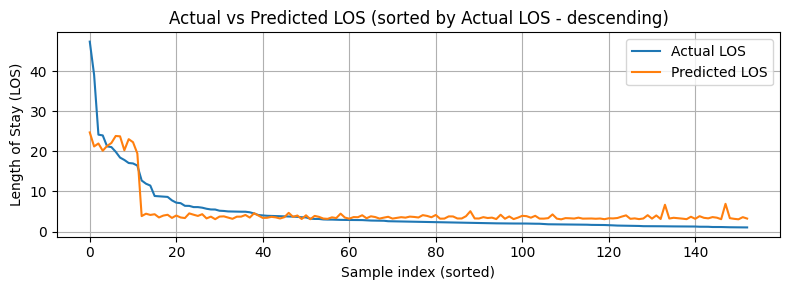

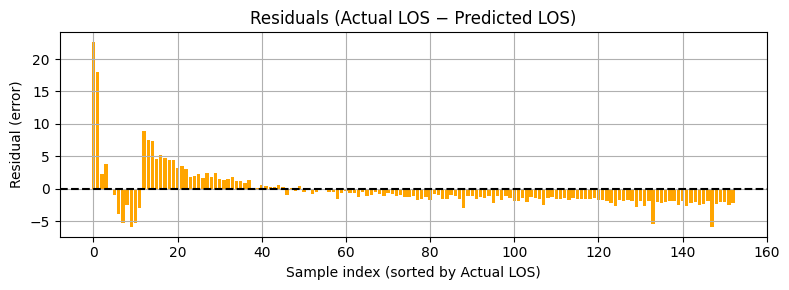

Plotting took 18.951043844223022 seconds


In [ ]:
start = time()

rf = RandomForestRegressor(featuresCol="pca_features", labelCol="LOS", numTrees=100)
rf_model = rf.fit(train_df)

print(f"Training took {time() - start} seconds")

start = time()
predictions = rf_model.transform(test_df)
print(f"Prediction took {time() - start} seconds")


start = time()
evaluator = RegressionEvaluator(labelCol="LOS", predictionCol="prediction")

mae  = evaluator.setMetricName("mae").evaluate(predictions)
mse  = evaluator.setMetricName("mse").evaluate(predictions)
rmse = evaluator.setMetricName("rmse").evaluate(predictions)
r2   = evaluator.setMetricName("r2").evaluate(predictions)
print(f"Evaluation took {time() - start} seconds")



print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")


start = time()
results = predictions.select("LOS", "prediction") \
    .sample(withReplacement=False, fraction=0.01, seed=42) \
    .orderBy("LOS", ascending=False) \
    .toPandas()

y_test_sorted = results["LOS"].values
y_pred_sorted = results["prediction"].values
residuals = y_test_sorted - y_pred_sorted

plt.figure(figsize=(8, 3))
plt.plot(y_test_sorted, label='Actual LOS')
plt.plot(y_pred_sorted, label='Predicted LOS')
plt.title('Actual vs Predicted LOS (sorted by Actual LOS - descending)')
plt.xlabel('Sample index (sorted)')
plt.ylabel('Length of Stay (LOS)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 3))
plt.bar(range(len(residuals)), residuals, color='orange')
plt.axhline(0, color='black', linestyle='--')
plt.title('Residuals (Actual LOS − Predicted LOS)')
plt.xlabel('Sample index (sorted by Actual LOS)')
plt.ylabel('Residual (error)')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Plotting took {time() - start} seconds")



2025-06-05 15:17:21,632 INFO XGBoost-PySpark: _fit Running xgboost-3.0.2 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'max_depth': 6, 'num_round': 100, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
25/06/05 15:17:22 WARN DAGScheduler: Broadcasting large task binary with size 1195.3 KiB
2025-06-05 15:17:35,541 INFO XGBoost-PySpark: _train_booster Training on CPUs 1]
[15:17:36] Task 0 got rank 0
/home/joaomonteiro/Desktop/BDCC/env_bdcc/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:17:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "num_round" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[15:17:38] [0]	training-rmse:5.38181
[15:17:38] [1]	training-rmse:4.68357
[15:17:38] [2]	training-rmse:4.22032
[15:17:38] [3]	training-rmse:3.93471
[15:17:38] [4]	training-rmse:3.72967
[15:17:38] [5]	training-rmse:3.57216
[15

Training took 77.06683087348938 seconds
Prediction took 0.13770747184753418 seconds


25/06/05 15:17:47 WARN DAGScheduler: Broadcasting large task binary with size 1638.5 KiB
2025-06-05 15:17:49,355 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
25/06/05 15:17:56 WARN DAGScheduler: Broadcasting large task binary with size 1638.5 KiB
2025-06-05 15:17:57,152 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
25/06/05 15:18:05 WARN DAGScheduler: Broadcasting large task binary with size 1638.5 KiB
2025-06-05 15:18:06,022 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
25/06/05 15:18:15 WARN DAGScheduler: Broadcasting large task binary with size 1638.5 KiB
2025-06-05 15:18:15,592 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


Evaluation took 37.30638122558594 seconds
MAE: 2.24
MSE: 18.81
RMSE: 4.34
R²: 0.59


25/06/05 15:18:24 WARN DAGScheduler: Broadcasting large task binary with size 1632.4 KiB
2025-06-05 15:18:24,740 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
25/06/05 15:18:32 WARN DAGScheduler: Broadcasting large task binary with size 1638.3 KiB
2025-06-05 15:18:33,181 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
25/06/05 15:18:40 WARN DAGScheduler: Broadcasting large task binary with size 1855.8 KiB


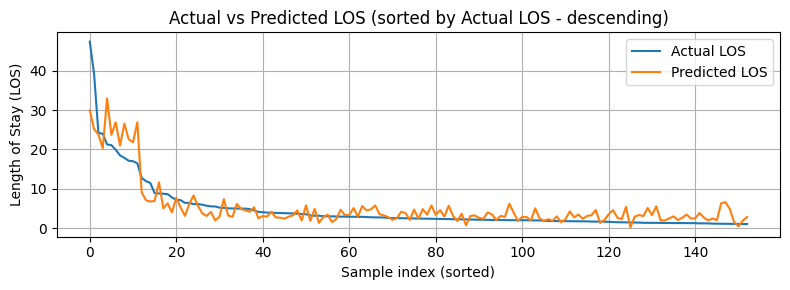

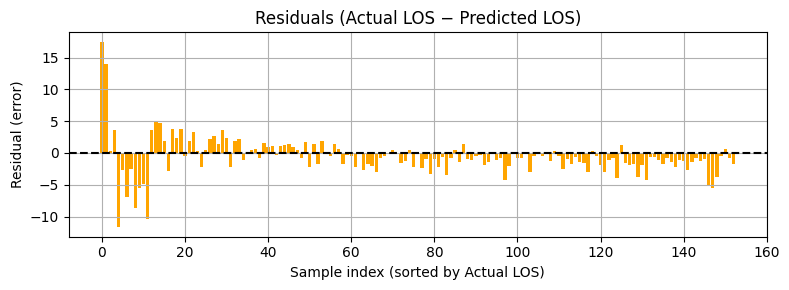

Plotting took 17.855326652526855 seconds


In [ ]:
xgb = SparkXGBRegressor(
    label_col="LOS",
    features_col="pca_features",
    prediction_col="prediction",
    num_round=100,
    max_depth=6
)

xgb_model = xgb.fit(train_df)

print(f"Training took {time() - start} seconds")

start = time()
predictions = xgb_model.transform(test_df)

print(f"Prediction took {time() - start} seconds")


start = time()
evaluator = RegressionEvaluator(labelCol="LOS", predictionCol="prediction")

mae  = evaluator.setMetricName("mae").evaluate(predictions)
mse  = evaluator.setMetricName("mse").evaluate(predictions)
rmse = evaluator.setMetricName("rmse").evaluate(predictions)
r2   = evaluator.setMetricName("r2").evaluate(predictions)
print(f"Evaluation took {time() - start} seconds")



print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")


start = time()
results = predictions.select("LOS", "prediction") \
    .sample(withReplacement=False, fraction=0.01, seed=42) \
    .orderBy("LOS", ascending=False) \
    .toPandas()

y_test_sorted = results["LOS"].values
y_pred_sorted = results["prediction"].values
residuals = y_test_sorted - y_pred_sorted

plt.figure(figsize=(8, 3))
plt.plot(y_test_sorted, label='Actual LOS')
plt.plot(y_pred_sorted, label='Predicted LOS')
plt.title('Actual vs Predicted LOS (sorted by Actual LOS - descending)')
plt.xlabel('Sample index (sorted)')
plt.ylabel('Length of Stay (LOS)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 3))
plt.bar(range(len(residuals)), residuals, color='orange')
plt.axhline(0, color='black', linestyle='--')
plt.title('Residuals (Actual LOS − Predicted LOS)')
plt.xlabel('Sample index (sorted by Actual LOS)')
plt.ylabel('Residual (error)')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Plotting took {time() - start} seconds")



In [29]:
print(f"Training data count: {train_df.count()}")
train_df.select("LOS", "pca_features").show(5)


25/06/05 15:45:47 WARN DAGScheduler: Broadcasting large task binary with size 1192.7 KiB


Training data count: 30364


25/06/05 15:45:57 WARN DAGScheduler: Broadcasting large task binary with size 1190.2 KiB


+------+--------------------+
|   LOS|        pca_features|
+------+--------------------+
|1.2564|[-9.4621353692466...|
|1.5071|[-8.3039855062826...|
|1.7333|[-7.2698290822373...|
|1.3933|[-6.9090238138679...|
|2.3793|[-6.6094207669812...|
+------+--------------------+
only showing top 5 rows



In [32]:
xgb = SparkXGBRegressor(
    label_col="LOS",
    features_col="pca_features",
    prediction_col="prediction"
)

# Define grid (2 × 2 = 4 configs)
paramGrid = ParamGridBuilder() \
    .addGrid(xgb.max_depth, [4, 6]) \
    .addGrid(xgb.learning_rate, [0.1, 0.3]) \
    .build()

# Evaluator
evaluator = RegressionEvaluator(
    labelCol="LOS",
    predictionCol="prediction",
    metricName="rmse"
)


tvs = TrainValidationSplit(
    estimator=xgb,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    trainRatio=0.8,  # Use 100% of the data for training, just like CV with 1 fold
    parallelism=2
)

tvs_model = tvs.fit(train_df)



25/06/05 15:48:44 WARN DAGScheduler: Broadcasting large task binary with size 1198.7 KiB
25/06/05 15:48:44 WARN DAGScheduler: Broadcasting large task binary with size 1198.7 KiB
2025-06-05 15:48:52,979 INFO XGBoost-PySpark: _fit Running xgboost-3.0.2 on 1 workers with
	booster params: {'device': 'cpu', 'learning_rate': 0.3, 'max_depth': 4, 'objective': 'reg:squarederror', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-06-05 15:48:52,983 INFO XGBoost-PySpark: _fit Running xgboost-3.0.2 on 1 workers with
	booster params: {'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 4, 'objective': 'reg:squarederror', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
25/06/05 15:48:53 WARN DAGScheduler: Broadcasting large task binary with size 1208.8 KiB
25/06/05 15:48:53 WARN DAGScheduler: Broadcasting large task binary

In [37]:
best_model = tvs_model.bestModel

best_params = best_model.extractParamMap()

# Optionally print
for param, value in best_params.items():
    if value != None:
        print(f"{param.name}: {value}")


enable_sparse_data_optim: False
featuresCol: pca_features
features_cols: []
labelCol: LOS
predictionCol: prediction
arbitrary_params_dict: {}
device: cpu
force_repartition: False
launch_tracker_on_driver: True
learning_rate: 0.1
max_depth: 4
missing: nan
n_estimators: 100
num_workers: 1
objective: reg:squarederror
repartition_random_shuffle: False
use_gpu: False
verbose: True


25/06/05 15:54:03 WARN DAGScheduler: Broadcasting large task binary with size 1199.5 KiB
2025-06-05 15:54:12,367 INFO XGBoost-PySpark: _fit Running xgboost-3.0.2 on 1 workers with
	booster params: {'device': 'cpu', 'objective': 'reg:squarederror', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
25/06/05 15:54:12 WARN DAGScheduler: Broadcasting large task binary with size 1209.6 KiB
2025-06-05 15:54:15,506 INFO XGBoost-PySpark: _train_booster Training on CPUs 1]
[15:54:16] Task 0 got rank 0
[15:54:17] [0]	training-rmse:5.37624
[15:54:17] [1]	training-rmse:4.64647
[15:54:17] [2]	training-rmse:4.22020
[15:54:17] [3]	training-rmse:3.85194
[15:54:17] [4]	training-rmse:3.63790
[15:54:17] [5]	training-rmse:3.46646
[15:54:18] [6]	training-rmse:3.33258
[15:54:18] [7]	training-rmse:3.23869
[15:54:18] [8]	training-rmse:3.14442
[15:54:18] [9]	training-rmse:3.08766
[15:54:18] [10]	training-rmse:3.03691
[15:54:18

Prediction took 0.06447768211364746 seconds


25/06/05 15:56:45 WARN DAGScheduler: Broadcasting large task binary with size 1638.5 KiB
2025-06-05 15:56:45,746 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
25/06/05 15:56:54 WARN DAGScheduler: Broadcasting large task binary with size 1638.5 KiB
2025-06-05 15:56:55,523 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
25/06/05 15:57:04 WARN DAGScheduler: Broadcasting large task binary with size 1638.5 KiB
2025-06-05 15:57:05,028 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
25/06/05 15:57:13 WARN DAGScheduler: Broadcasting large task binary with size 1638.5 KiB
2025-06-05 15:57:14,531 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


Evaluation took 37.63798642158508 seconds
MAE: 2.24
MSE: 18.81
RMSE: 4.34
R²: 0.59


25/06/05 15:57:23 WARN DAGScheduler: Broadcasting large task binary with size 1632.3 KiB
2025-06-05 15:57:23,706 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
25/06/05 15:57:31 WARN DAGScheduler: Broadcasting large task binary with size 1638.3 KiB
2025-06-05 15:57:32,183 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
25/06/05 15:57:39 WARN DAGScheduler: Broadcasting large task binary with size 1855.8 KiB


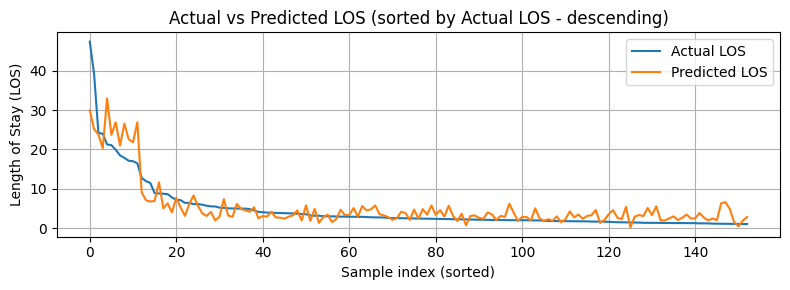

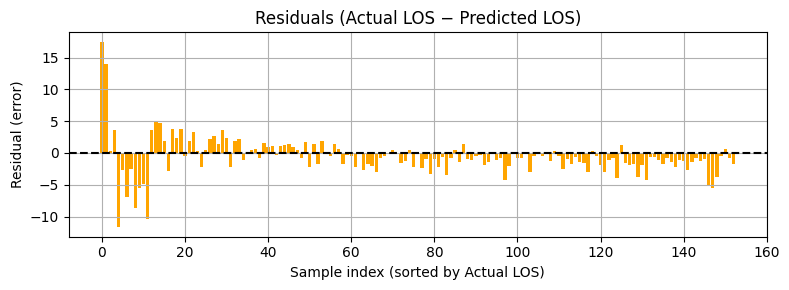

Plotting took 18.391497135162354 seconds


In [41]:
xgb_best = SparkXGBRegressor(
    label_col="LOS",
    features_col="pca_features",
    prediction_col="prediction",
    max_depth=best_params[xgb.getParam("max_depth")],
    learning_rate=best_params[xgb.getParam("learning_rate")]
)


evaluator = RegressionEvaluator(
    labelCol="LOS",
    predictionCol="prediction",
    metricName="rmse"
)

paramGrid = ParamGridBuilder().build()

cv = CrossValidator(
    estimator=xgb,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5,
    parallelism=2
)

cv_model = cv.fit(train_df)


avg_metrics = cv_model.avgMetrics

print("Cross-Validation Metrics (per paramMap):")
for i, metric in enumerate(avg_metrics):
    print(f"Model {i + 1}: RMSE = {metric:.4f}")


start = time()
predictions = cv_model.transform(test_df)

print(f"Prediction took {time() - start} seconds")


start = time()
evaluator = RegressionEvaluator(labelCol="LOS", predictionCol="prediction")

mae  = evaluator.setMetricName("mae").evaluate(predictions)
mse  = evaluator.setMetricName("mse").evaluate(predictions)
rmse = evaluator.setMetricName("rmse").evaluate(predictions)
r2   = evaluator.setMetricName("r2").evaluate(predictions)
print(f"Evaluation took {time() - start} seconds")



print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")


start = time()
results = predictions.select("LOS", "prediction") \
    .sample(withReplacement=False, fraction=0.01, seed=42) \
    .orderBy("LOS", ascending=False) \
    .toPandas()

y_test_sorted = results["LOS"].values
y_pred_sorted = results["prediction"].values
residuals = y_test_sorted - y_pred_sorted

plt.figure(figsize=(8, 3))
plt.plot(y_test_sorted, label='Actual LOS')
plt.plot(y_pred_sorted, label='Predicted LOS')
plt.title('Actual vs Predicted LOS (sorted by Actual LOS - descending)')
plt.xlabel('Sample index (sorted)')
plt.ylabel('Length of Stay (LOS)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 3))
plt.bar(range(len(residuals)), residuals, color='orange')
plt.axhline(0, color='black', linestyle='--')
plt.title('Residuals (Actual LOS − Predicted LOS)')
plt.xlabel('Sample index (sorted by Actual LOS)')
plt.ylabel('Residual (error)')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Plotting took {time() - start} seconds")

